In [1]:
import os 
import numpy as np 
import emcee 
import time
import pandas as pd
import matplotlib.pylab as plt 
import random

# NUTS
from numpyro.diagnostics import summary
import jax
import jax.numpy as jnp 
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_median
from numpyro.handlers import seed

os.makedirs('mvn', exist_ok=True)
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (8,6)
fontSize = 20

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]='.10'

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
dimensions = np.arange(1, 11, 1, dtype = int) * 10

EPS = 0.01
NWARMUP = 500 
TREEDEPTH = 8 
NSAMPLES_NUTS = 15000
NSAMPLES_EMCEE = 2000
THIN = 10

# Sample Multivariate Normal with EMCEE

In [3]:
def emcee_log_prob(position, mean, covariance):
    diff = position - mean
    return -0.5 * np.dot(diff, np.linalg.solve(covariance, diff))
    
def emcee_sampler(ndim, nsamples = 10000):
    mean = np.zeros(ndim)
    cov = np.eye(ndim)
    nwalkers = 2 * ndim 
    initial_1 = np.random.rand(nwalkers, ndim)
    initial_2 = np.random.rand(nwalkers, ndim)

    # we use two samplers (to compute the Gelman-Rubin statistics)
    sampler_1 = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob, args=[mean, cov])
    runsampler_1 = sampler_1.run_mcmc(initial_1, nsamples, progress = True)
    samples_1 = sampler_1.flatchain
    ap_1 = np.mean(sampler_1.acceptance_fraction)

    sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob, args=[mean, cov])
    runsampler_2 = sampler_2.run_mcmc(initial_2, nsamples, progress = True)
    samples_2 = sampler_2.flatchain
    ap_2 = np.mean(sampler_2.acceptance_fraction)

    return samples_1, samples_2, mean, cov, ap_1, ap_2

def calculate_mean_cov(samples, thin = None):
    """
    The input is of shape N x p, where N is the number of samples and p is the number of dimensions. 
    """
    if thin is not None:
        samples = samples[0::thin]
    sample_mean = np.mean(samples, axis = 0)
    sample_cov = np.cov(samples.T)
    return sample_mean, sample_cov

def calculate_summary(samples_1, samples_2, nlike, thin = None, ndecimal = 3):
    record = []
    for i in range(samples_1.shape[1]):
        if thin is not None:
            x1 = samples_1[:,i][0::thin]
            x2 = samples_2[:,i][0::thin]
        else:
            x1 = samples_1[:,i]
            x2 = samples_2[:,i]
            
        testsamples = np.vstack(([x1, x2]))
        summary_stats = summary(testsamples)
        summary_stats[f'p_{i}'] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(ndecimal).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    nsamples = x1.shape[0] + x2.shape[0] # samples_1.shape[0] + samples_2.shape[0]
    record_df['n_eff'] /= nsamples # nlike
    return record_df
    
def compute_kl(mean0, mean1, cov0, cov1):
    cov1_inv = np.linalg.inv(cov1)
    ndim = cov1.shape[0]
    term1 = np.trace(cov1_inv @ cov0) - ndim 
    term2 = (mean1 - mean0) @ cov1_inv @ (mean1 - mean0)
    sign0, logdet0 = np.linalg.slogdet(cov0)
    sign1, logdet1 = np.linalg.slogdet(cov1)
    term3 = sign1 * logdet1 - sign0 * logdet0 
    return 0.5*(term1 + term2 + term3)

In [4]:
emcee_record_stats = list()
emcee_record_kl = list()
emcee_record_time = list()
emcee_record_ap = list()

for d in dimensions:

    # generate the samples 
    start_time = time.time()
    samples_1, samples_2, true_mean, true_cov, ap_1, ap_2 = emcee_sampler(d, nsamples = NSAMPLES_EMCEE)
    time_taken = time.time() - start_time

    # calculate sample mean and covariance
    sample_mean, sample_cov = calculate_mean_cov(np.vstack([samples_1, samples_2]), thin = THIN)

    # calculate KL divergence
    emcee_kl = compute_kl(sample_mean, true_mean, sample_cov, true_cov)

    # record quantities 
    emcee_record_stats.append(calculate_summary(samples_1, samples_2, 2 * d * NSAMPLES_EMCEE, thin = THIN))
    emcee_record_kl.append(emcee_kl)
    emcee_record_time.append(time_taken)
    emcee_record_ap.append([ap_1.item(), ap_2.item()])

    # print value of KL 
    print(f'KL-divergence is {emcee_kl:.4f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2190.31it/s]


KL-divergence is 0.2351


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 881.18it/s]


KL-divergence is 1.0597


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 506.44it/s]


KL-divergence is 2.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 327.96it/s]


KL-divergence is 6.3835


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.91it/s]


KL-divergence is 9.7702


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 160.13it/s]


KL-divergence is 13.9128


100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.08it/s]


KL-divergence is 20.9309


100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 86.31it/s]


KL-divergence is 28.1508


100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.86it/s]


KL-divergence is 35.0303


100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 44.36it/s]


KL-divergence is 43.8287


# NUTS

In [5]:
def nuts_model(ndim = 5):
    locs = jnp.zeros(ndim)
    covs = jnp.eye(ndim)
    mvn = dist.MultivariateNormal(loc = locs, covariance_matrix = covs)
    numpyro.sample('y', mvn)
    return locs, covs

In [6]:
%%capture
def run_nuts(dimension):
    
    nuts_kernel = NUTS(nuts_model, 
                       step_size=EPS, 
                       init_strategy=init_to_median, 
                       dense_mass=True, 
                       max_tree_depth=TREEDEPTH)

    mcmc = MCMC(nuts_kernel, 
                num_chains=2, 
                num_warmup = NWARMUP, 
                num_samples=NSAMPLES_NUTS, 
                chain_method="vectorized")
    
    mcmc.run(jax.random.PRNGKey(random.randint(0, 1000)), 
             ndim=dimension, 
             extra_fields=('potential_energy', 'num_steps'))
    return mcmc

In [7]:
record_nsteps = list()
nuts_record_kl = list()
nuts_record_stats = list()
nuts_record_time = list()
nuts_record_ap = list()

for d in dimensions:
    start_time = time.time()
    mcmc = run_nuts(d)
    time_taken = time.time() - start_time 
    samples = np.asarray(mcmc.get_samples()['y'])
    samples_grouped = np.asarray(mcmc.get_samples(group_by_chain=True)['y'])
    nsteps = mcmc.get_extra_fields(group_by_chain=True)['num_steps']
    nevaluations = jnp.sum(nsteps).item()
    
    # calculate sample mean and covariance 
    nuts_mean, nuts_cov = calculate_mean_cov(samples, thin = THIN)

    # calculate the KL divergence 
    nuts_kl = compute_kl(nuts_mean, np.zeros(d), nuts_cov, np.eye(d))

    # record quantities 
    nuts_record_stats.append(calculate_summary(samples_grouped[0], samples_grouped[1], nevaluations, thin = THIN))
    record_nsteps.append(nsteps)
    nuts_record_kl.append(nuts_kl)
    nuts_record_time.append(time_taken)
    nuts_record_ap.append(mcmc.last_state.mean_accept_prob)

    # print KL divergence 
    print(f'KL-divergence is {nuts_kl:.4f}')

sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [00:43<00:00, 355.84it/s]


KL-divergence is 0.0131


sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [00:40<00:00, 382.27it/s]


KL-divergence is 0.0426


sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [01:02<00:00, 246.22it/s]


KL-divergence is 0.0838


sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [01:23<00:00, 185.94it/s]


KL-divergence is 0.1571


sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [01:39<00:00, 156.48it/s]


KL-divergence is 0.2246


sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [01:46<00:00, 146.12it/s]


KL-divergence is 0.3210


sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [01:59<00:00, 129.73it/s]


KL-divergence is 0.4270


sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [02:09<00:00, 119.98it/s]


KL-divergence is 0.5838


sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [02:34<00:00, 100.14it/s]


KL-divergence is 0.6962


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [03:15<00:00, 79.14it/s]


KL-divergence is 0.8847


# Compare Results

In [8]:
def compare_stats(emcee_df, nuts_df):
    nexperiments = len(emcee_df)
    record_rhat = {'emcee': list(), 'nuts': list()}
    record_neff = {'emcee': list(), 'nuts': list()}
    for i in range(nexperiments):
        emcee_mean_stats = emcee_df[i].mean(0)
        nuts_mean_stats = nuts_df[i].mean(0)
        record_rhat['emcee'].append(emcee_mean_stats['r_hat'].item())
        record_neff['emcee'].append(emcee_mean_stats['n_eff'].item())
        record_rhat['nuts'].append(nuts_mean_stats['r_hat'].item())
        record_neff['nuts'].append(nuts_mean_stats['n_eff'].item())
    return pd.DataFrame(record_rhat, index = dimensions), pd.DataFrame(record_neff, index = dimensions)

In [9]:
df_rhat, df_neff = compare_stats(emcee_record_stats, nuts_record_stats)
df_kl = pd.DataFrame(np.vstack([emcee_record_kl, nuts_record_kl]).T, columns = ['emcee', 'nuts'], index=dimensions)
df_ap = pd.DataFrame(np.vstack([np.mean(emcee_record_ap, 1), np.mean(nuts_record_ap, 1)]).T, columns = ['emcee', 'nuts'], index=dimensions)

## Plots

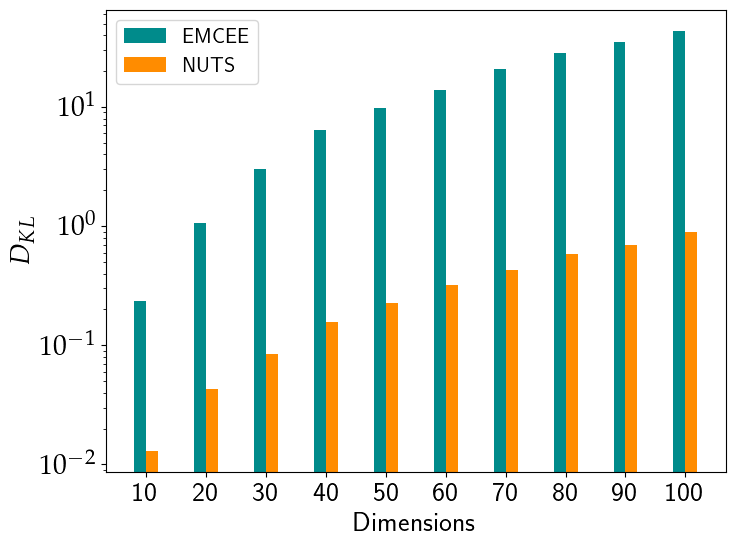

In [10]:
index = np.arange(len(dimensions))
bar_width = 0.20

fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, df_kl['emcee'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, df_kl['nuts'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$D_{KL}$', fontsize = fontSize)
# ax.set_title('KL Divergence', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
ax.set_yscale('log')
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig('mvn/kl.pdf', bbox_inches = 'tight')
plt.show()

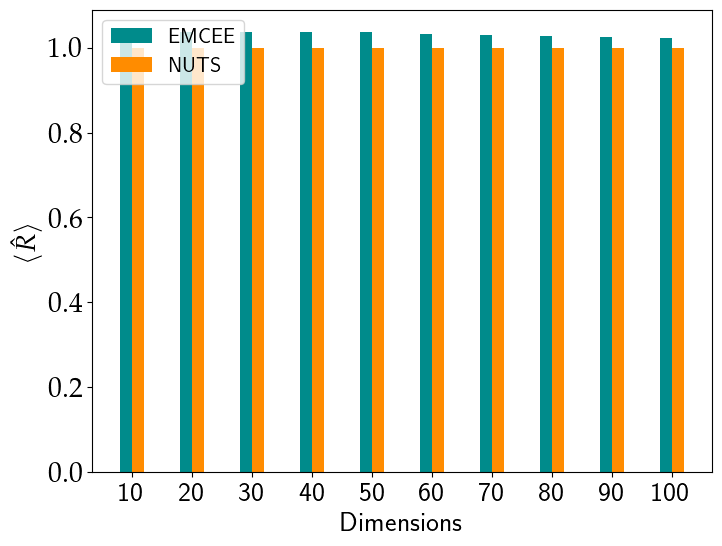

In [11]:
fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, df_rhat['emcee'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, df_rhat['nuts'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$\langle \hat{R} \rangle$', fontsize = fontSize)
# ax.set_title('Gelman-Rubin Statistics', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
# ax.set_yscale('log')
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig('mvn/gr.pdf', bbox_inches = 'tight')
plt.show()

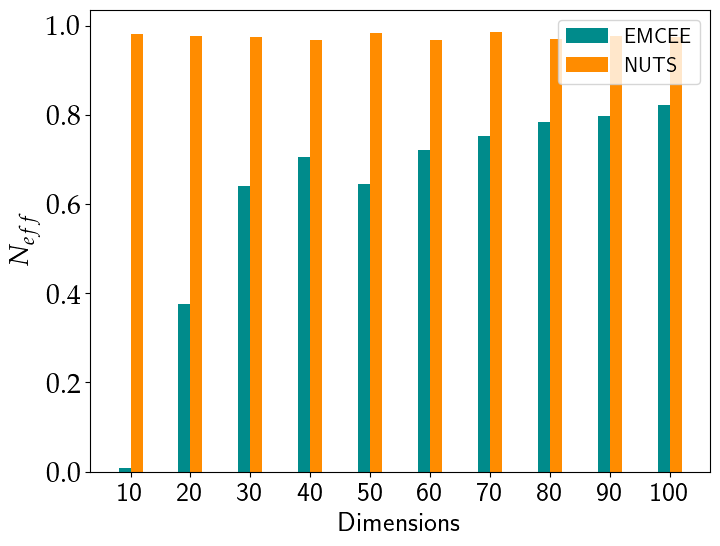

In [12]:
fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, df_neff['emcee'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, df_neff['nuts'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$N_{eff}$', fontsize = fontSize)
# ax.set_title('Scaled Effective Sample Size', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
# ax.set_yscale('log')
ax.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig('mvn/neff.pdf', bbox_inches = 'tight')
plt.show()

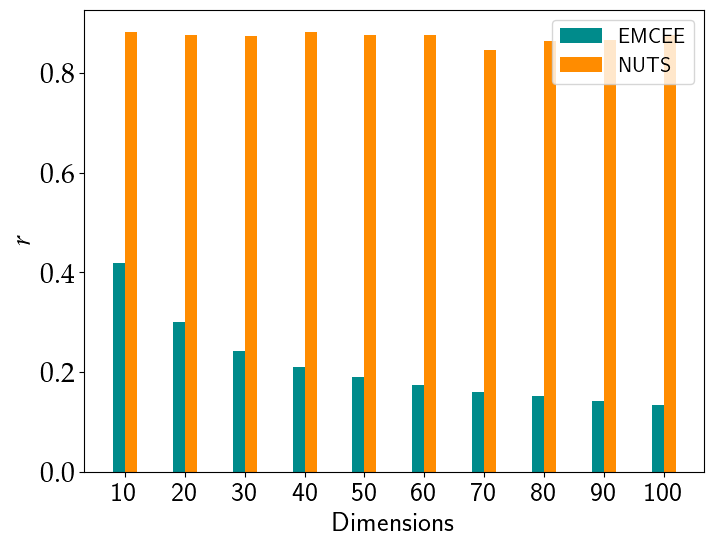

In [13]:
fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, df_ap['emcee'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, df_ap['nuts'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$r$', fontsize = fontSize)
# ax.set_title('Acceptance Probability', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
# ax.set_yscale('log')
ax.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig('mvn/ap.pdf', bbox_inches = 'tight')
plt.show()

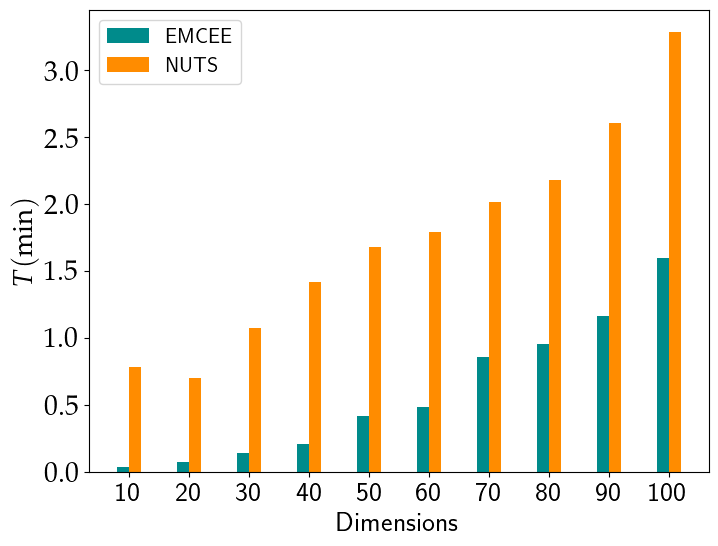

In [14]:
fig, ax = plt.subplots(figsize=figSize)
# conversion from seconds to minutes, hence factor of 60
emcee_column = ax.bar(index, np.asarray(emcee_record_time) / 60, bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, np.asarray(nuts_record_time) / 60, bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$T (\textrm{min})$', fontsize = fontSize)
# ax.set_title('Time taken (2 chains)', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
# ax.set_yscale('log')
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig('mvn/time.pdf', bbox_inches = 'tight')
plt.show()

In [15]:
nuts_nlike = np.sum(record_nsteps, 2).sum(1)
emcee_nlike = np.vstack([dimensions * 2 * NSAMPLES_EMCEE] * 2).T.sum(1)

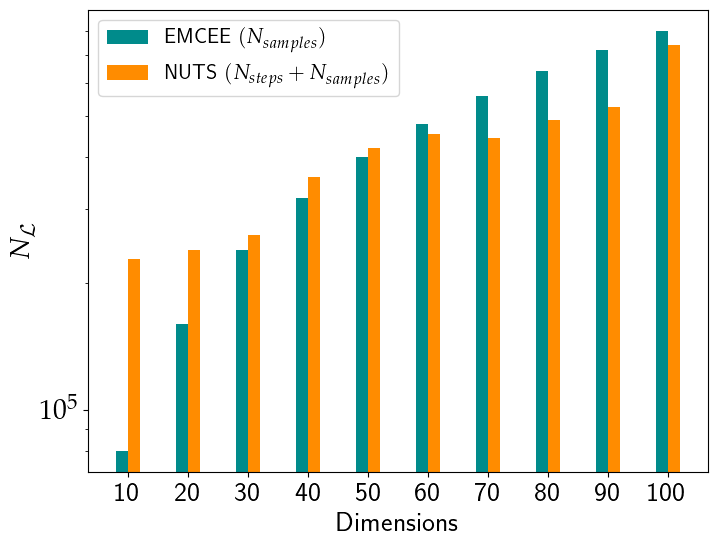

In [16]:
fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, emcee_nlike, bar_width, label="EMCEE $(N_{samples})$", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, nuts_nlike + 2 * NSAMPLES_NUTS, bar_width, label="NUTS $(N_{steps} + N_{samples})$", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$N_{\mathcal{L}}$', fontsize = fontSize)
# ax.set_title('Number of likelihood evaluations (2 chains)', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
ax.set_yscale('log')
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig('mvn/nlike.pdf', bbox_inches = 'tight')
plt.show()

### High Effective Sample Size

https://stats.stackexchange.com/questions/296059/effective-sample-size-greater-than-actual-sample-size

If the estimated effective sample size is larger than the number of samples, this likely means that there is negative estimated autocorrelation in your samples. If you run an acf on your samples, you will most certainly find negative correlation.

In [17]:
from numpyro.diagnostics import autocorrelation

In [18]:
x_original_1 = samples_grouped[0][:,0]
x_original_2 = samples_grouped[1][:,0]

In [19]:
test = np.vstack([x_original_1, x_original_2])
print(summary(test)['Param:0']['n_eff'] / (x_original_1.shape[0] + x_original_2.shape[0]))

1.0414223547922954


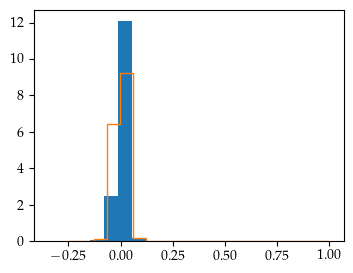

In [20]:
plt.figure(figsize=(4,3))
plt.hist(autocorrelation(x_original_1), density = True, bins = 20)
plt.hist(autocorrelation(x_original_2), histtype = 'step', density = True, bins = 20)
plt.show()

In [21]:
for t in np.arange(2, 22, 2):
    x1 = x_original_1[0::t]
    x2 = x_original_2[0::t]
    test = np.vstack([x1, x2])
    print(summary(test)['Param:0']['n_eff'] / (x1.shape[0] + x2.shape[0]))

0.8441328634707929
0.8486249549305513
0.9574020565491981
0.8314202301029179
1.0101931170237082
0.9416588515304802
1.0836029821806552
0.967760559728489
0.9438408968784625
1.0190335460415962
